#### replicate the MAXSER method (w/o factor) in:
#### Ao, Mengmeng and Li, Yingying and Li, Yingying and Zheng, Xinghua, Approaching Mean-Variance Efficiency for Large Portfolios (July 7, 2018). Available at SSRN: https://ssrn.com/abstract=2699157 or http://dx.doi.org/10.2139/ssrn.2699157

#### *received help from Professor Raymond Kan

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import betainc, beta
from sklearn.linear_model import lars_path

In [5]:
data = pd.read_csv("./return_data.csv")
data["index"] = pd.to_datetime(data["index"], format="%Y-%m-%d")
data = data.set_index("index")

In [6]:
mu = data.mean()
sigma = data.cov()
theta = mu.values.T @ np.linalg.inv(sigma.values) @ mu.values

vol_max = 0.04
sim = 100
periods = 240

vol_os = []
sr_os = []

# plug-in
for i in range(sim):
    r = np.random.multivariate_normal(mu,sigma, periods)
    mu_hat = np.mean(r,axis=0)
    sigma_hat = np.cov(r, rowvar=False)
    sigma_hat_inv = np.linalg.inv(sigma_hat)
    theta_hat = mu_hat.T @ sigma_hat_inv @ mu_hat
    w_hat = vol_max / np.sqrt(theta_hat) * (mu_hat.T @ sigma_hat_inv)
    vol = np.sqrt(w_hat.T @ sigma @ w_hat)
    vol_os.append(vol)
    sr_os.append(w_hat.T @ mu / vol)

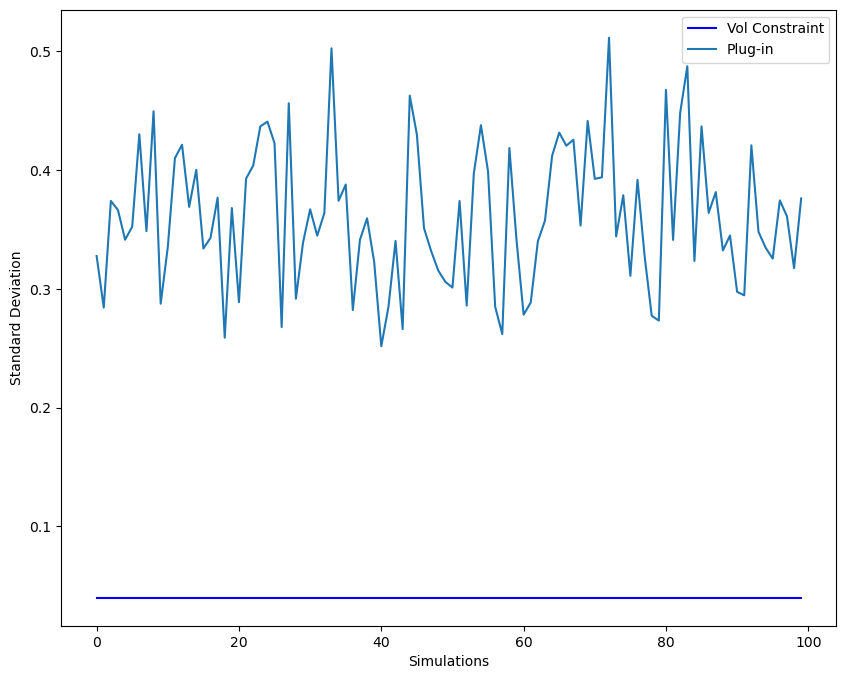

In [7]:
x = range(sim)
y = np.ones(sim)
plt.figure(figsize=(10,8))
plt.plot(x,y*vol_max,'b-',x,vol_os)
plt.xlabel("Simulations")
plt.ylabel("Standard Deviation")
plt.legend(["Vol Constraint","Plug-in"])
plt.show()

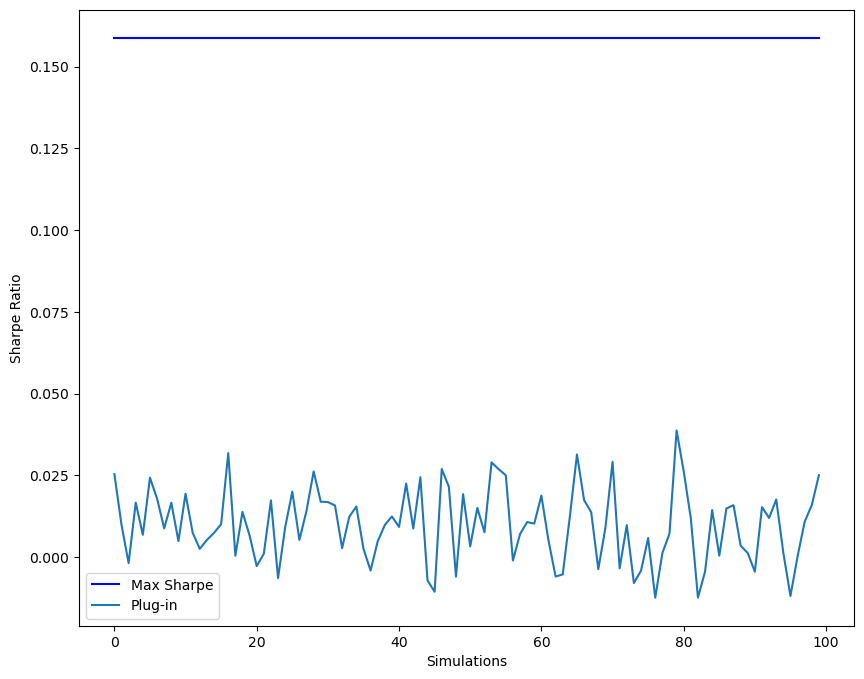

In [8]:
x = range(sim)
y = np.ones(sim)
plt.figure(figsize=(10,8))
plt.plot(x,y*np.sqrt(theta),'b-',x,sr_os)
plt.xlabel("Simulations")
plt.ylabel("Sharpe Ratio")
plt.legend(["Max Sharpe","Plug-in"])
plt.show()

In [10]:
# adjusted theta
def adj_theta(periods, assets, mu_hat, sigma_hat_inv):
    theta_sample = mu_hat.T @ sigma_hat_inv @ mu_hat
    adj_theta = ((periods - assets - 2) * theta_sample - assets) / periods + \
                2 * theta_sample ** (assets / 2) * (1 + theta_sample) ** (-1 * (periods - 2)/ 2) / periods / \
                (betainc(assets/2, (periods - assets)/2, theta_sample / (1 + theta_sample)) * beta(assets/2, (periods - assets)/ 2))
    return adj_theta

k = 10 
vol_maxser = []
sr_maxser = []

# MAXSER
for j in range(sim):
    r = np.random.multivariate_normal(mu,sigma, periods)
    mu_hat = np.mean(r,axis=0)
    sigma_hat = np.cov(r, rowvar=False)
    sigma_hat_inv = np.linalg.inv(sigma_hat)
    theta_hat = adj_theta(periods,data.shape[1],mu_hat,sigma_hat_inv)
    rc = vol_max * (1 + theta_hat) / np.sqrt(theta_hat)
    rc = rc * np.ones(r.shape[0])
    zeta_arr = np.zeros(k)
    
    # cross validation
    for i in range(k):
        bound = (int((periods) * (i) / k), int((periods) * (i + 1) / k - 1))
        r_cv = np.delete(r, range(bound[0],bound[1]), axis=0)
        _,_,coef = lars_path(r_cv, rc[:r_cv.shape[0]], method="lasso")
        a = r @ coef
        b = a.std(axis=0)
        c = np.argmin(np.abs(b - vol_max))
        w = coef[:,c]
        zeta_arr[i] = np.linalg.norm(w,1) / np.linalg.norm(coef[:,-1],1)
    zeta_valid = zeta_arr.mean()
    _, _, coef_full = lars_path(r, rc, method="lasso")
    zeta_full = np.linalg.norm(coef_full,1, axis=0) / np.linalg.norm(coef_full[:,-1],1)
    ind = np.min(np.argwhere(zeta_valid < zeta_full))
    w_full = coef_full[:,ind]
    vol = np.sqrt(w_full.T @ sigma @ w_full)
    vol_maxser.append(vol)
    sr_maxser.append(w_full.T @ mu / vol)

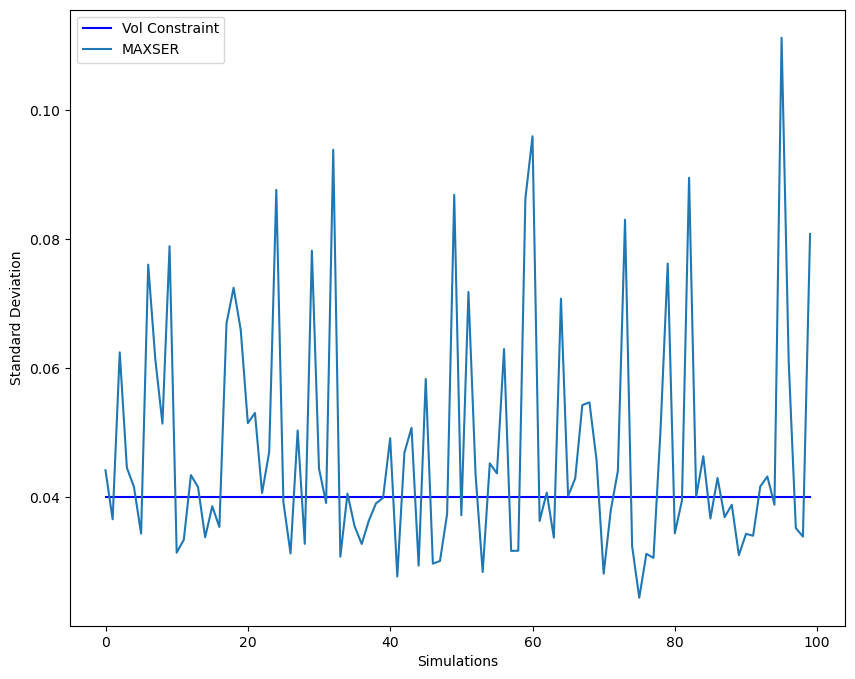

In [11]:
x = range(sim)
y = np.ones(sim)
plt.figure(figsize=(10,8))
plt.plot(x,y*vol_max,'b-',x,vol_maxser)
plt.xlabel("Simulations")
plt.ylabel("Standard Deviation")
plt.legend(["Vol Constraint","MAXSER"])
plt.show()

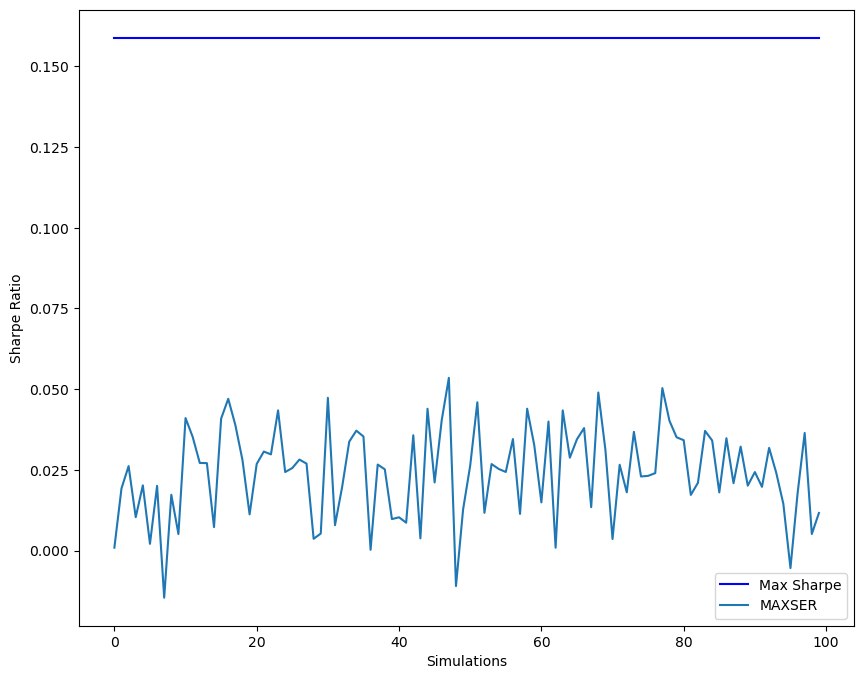

In [12]:
x = range(sim)
y = np.ones(sim)
plt.figure(figsize=(10,8))
plt.plot(x,y*np.sqrt(theta),'b-',x,sr_maxser)
plt.xlabel("Simulations")
plt.ylabel("Sharpe Ratio")
plt.legend(["Max Sharpe","MAXSER"])
plt.show()